# Obesity Rate Correlation Analysis

* The analysis will encompass data from the states of California, Ohio, and South Carolina.
* The objective is to find if there is correlation between obesity rate and the following measurements: 
    * Median household income
    * % With access to exercise opportunities
    * % of physically inactive
    * Primary care physicians rate
    * High School Unemployment rate
    * Unemployed rate
    

In [15]:
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import linregress
from pprint import pprint

In [16]:
# Countyhealthrankings data for California, Ohio and South Carolina
# source https://www.countyhealthrankings.org/

csvpath_california = "./2020 County Health Rankings California Data - v1_0.csv"
csvpath_ohio = "./2020 County Health Rankings Ohio Data - v1_0.csv"
csvpath_south_carolina = "./2020 County Health Rankings South Carolina Data - v1_0.csv"

In [24]:
# Census URL to collect median household income for 2018 for every state and county

url = "https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*"
print(url)

https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=county:*&in=state:*


## Data Cleaning
* Cleaning Data from the US Census and countyhealthrankings for the following states:
    * California 
    * Ohio
    * South Carolina

In [25]:
# Converting census request into a DataFrame

census_data = requests.get(url).json()
df = pd.DataFrame(census_data).drop([0,])
df.head()

,0,1,2,3
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [26]:
# Renaming column headers from US Census data

new_df = df.rename(columns = {0:"County and State",
                             1:"Median Income",
                             2:"State Code",
                             3: "County Code"})
new_df.head()

,County and State,Median Income,State Code,County Code
1,"Washington County, Mississippi",30834,28,151
2,"Perry County, Mississippi",39007,28,111
3,"Choctaw County, Mississippi",37203,28,019
4,"Itawamba County, Mississippi",40510,28,057
5,"Carroll County, Mississippi",43060,28,015


In [27]:
# Combining State and County Code in order to merge the DataFrame with the Countyhealthrankings
# DataFrame

new_df["FIPS"] = new_df["State Code"].astype(str) + new_df["County Code"].astype(str)
new_df.head()

,County and State,Median Income,State Code,County Code,FIPS
1,"Washington County, Mississippi",30834,28,151,28151
2,"Perry County, Mississippi",39007,28,111,28111
3,"Choctaw County, Mississippi",37203,28,019,28019
4,"Itawamba County, Mississippi",40510,28,057,28057
5,"Carroll County, Mississippi",43060,28,015,28015


In [28]:
# Splitting the County and State column and creating two new columns for "County" and "State"
# to filter by California, Ohio and South Carolina

split_county_state = new_df["County and State"].str.split(",", n = 0, expand = True) 
new_df["County"]= split_county_state[0]
new_df["State"] = split_county_state[1]
new_df.head()

,County and State,Median Income,State Code,County Code,FIPS,County,State
1,"Washington County, Mississippi",30834,28,151,28151,Washington County,Mississippi
2,"Perry County, Mississippi",39007,28,111,28111,Perry County,Mississippi
3,"Choctaw County, Mississippi",37203,28,019,28019,Choctaw County,Mississippi
4,"Itawamba County, Mississippi",40510,28,057,28057,Itawamba County,Mississippi
5,"Carroll County, Mississippi",43060,28,015,28015,Carroll County,Mississippi


In [29]:
# Filtering data for the states of California, Ohio and South Carolina
# Selecting only needed columns for "County and State","Median Income","State and County Code", and "State"
selected_states = []
clean_data = new_df[["County and State","Median Income","FIPS","State"]].sort_values(by=['FIPS'])
states = [" California"," Ohio"," South Carolina"]
selected_states = clean_data.loc[(clean_data["State"]==" California") | (clean_data["State"]==" Ohio") | (clean_data["State"]==" South Carolina") ]
selected_states.head()

,County and State,Median Income,FIPS,State
1864,"Alameda County, California",92574,06001,California
1872,"Alpine County, California",64688,06003,California
1893,"Amador County, California",61198,06005,California
1884,"Butte County, California",48443,06007,California
1888,"Calaveras County, California",58151,06009,California


In [30]:
# create a copy of the selected_states DataFrame in order to cast the FIPS and Median Income columns as integer

selected_states_copy = selected_states.copy()
selected_states_copy["FIPS"] = selected_states["FIPS"].astype(int)
selected_states_copy["Median Income"] = selected_states["Median Income"].astype(int)
selected_states_copy.dtypes

County and State    object
Median Income        int32
FIPS                 int32
State               object
dtype: object

In [31]:
# Read all csv files for California, Ohio and South Carolina.
# Extract only columns needed for analysis

california_df = pd.read_csv(csvpath_california)
ohio_df = pd.read_csv(csvpath_ohio)
south_carolina_df = pd.read_csv(csvpath_south_carolina)

ca_health_df = california_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
ohio_health_df = ohio_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]
south_carolina_health_df = south_carolina_df[["FIPS","% Adults with Obesity","% Physically Inactive","% With Access to Exercise Opportunities","Primary Care Physicians Rate","High School Graduation Rate","% Unemployed"]]


In [32]:
# Concatenating all health data from countyhealth rankings for the three states into one DataFrame

all_states = [ca_health_df,ohio_health_df,south_carolina_health_df]
state_health_df = pd.concat(all_states)
state_health_df

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,6000,24,18,93,79,83.0,4.2
1,6001,19,15,100,110,87.0,3.0
2,6003,23,21,100,0,NaN,4.6
3,6005,30,25,76,67,88.0,4.0
4,6007,27,22,84,61,85.0,5.0
...,...,...,...,...,...,...,...
42,45083,32,28,77,68,88.0,3.1
43,45085,38,28,69,51,84.0,4.0
44,45087,39,30,65,40,76.0,4.1
45,45089,42,34,20,16,86.0,5.4


In [33]:
state_health_df.astype({'FIPS': 'str'}).dtypes

FIPS                                        object
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
dtype: object

In [34]:
# Add 0 to the front of State/County code
# Used apply function along with format. Apply passes a function and applies it to every value in the series. 
# {:0>5}'.format | padding and aligning strings. :0 refers to the character we want to use to pad, in this case 0. 
# > tells it to align to the right. The 5 is the length of the returned character/digit. 
# In this case since the FIPS is only 4 digits this will apply one 0 to the front, making it a total of 5 digits
# https://www.w3resource.com/python/python-format.php
# https://www.geeksforgeeks.org/python-pandas-apply/

format_FIPS = state_health_df['FIPS'].apply('{:0>5}'.format)

In [35]:
# Converting the formated FIPS to a DataFrame

FIPS_df = pd.DataFrame(format_FIPS)

In [36]:
# Replacing the formatted FIPS column to the DataFrame

state_health_df["FIPS"] = FIPS_df
state_health_df

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed
0,06000,24,18,93,79,83.0,4.2
1,06001,19,15,100,110,87.0,3.0
2,06003,23,21,100,0,NaN,4.6
3,06005,30,25,76,67,88.0,4.0
4,06007,27,22,84,61,85.0,5.0
...,...,...,...,...,...,...,...
42,45083,32,28,77,68,88.0,3.1
43,45085,38,28,69,51,84.0,4.0
44,45087,39,30,65,40,76.0,4.1
45,45089,42,34,20,16,86.0,5.4


In [37]:
# state_health_df.dtypes
state_health_df_copy = state_health_df.copy()
state_health_df_copy["FIPS"] = state_health_df["FIPS"].astype(int)
state_health_df_copy.dtypes


FIPS                                         int32
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
dtype: object

In [38]:
# Merge data from the US census and countyhealthrankings into one DataFrame and drop NA

merged_df = pd.merge(state_health_df_copy,selected_states_copy,on="FIPS",how="left")
merged_df.dropna()

,FIPS,% Adults with Obesity,% Physically Inactive,% With Access to Exercise Opportunities,Primary Care Physicians Rate,High School Graduation Rate,% Unemployed,County and State,Median Income,State
1,6001,19,15,100,110,87.0,3.0,"Alameda County, California",92574.0,California
3,6005,30,25,76,67,88.0,4.0,"Amador County, California",61198.0,California
4,6007,27,22,84,61,85.0,5.0,"Butte County, California",48443.0,California
5,6009,31,31,60,44,90.0,4.0,"Calaveras County, California",58151.0,California
6,6011,41,28,75,32,89.0,12.9,"Colusa County, California",56704.0,California
...,...,...,...,...,...,...,...,...,...,...
190,45083,32,28,77,68,88.0,3.1,"Spartanburg County, South Carolina",50179.0,South Carolina
191,45085,38,28,69,51,84.0,4.0,"Sumter County, South Carolina",43792.0,South Carolina
192,45087,39,30,65,40,76.0,4.1,"Union County, South Carolina",40120.0,South Carolina
193,45089,42,34,20,16,86.0,5.4,"Williamsburg County, South Carolina",32351.0,South Carolina


# Correlation and Regression Analysis

## State of Ohio

#### Obesity vs. % Physically Inactive

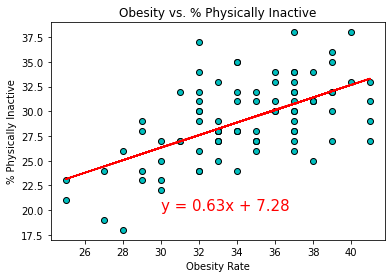

The r-squared value is: 0.5885488413368728


In [36]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_physical = ohio_analysis["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_physical)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_physical,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. % With Access to Exercise Opportunities

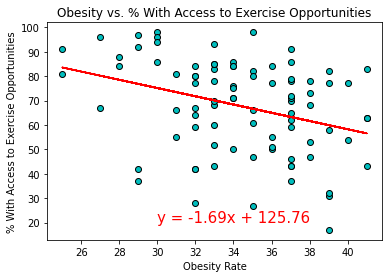

The r-squared value is: -0.3300541775387202


In [37]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_exercise = ohio_analysis["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_exercise)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_exercise,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. Primary Care Physicians Rate

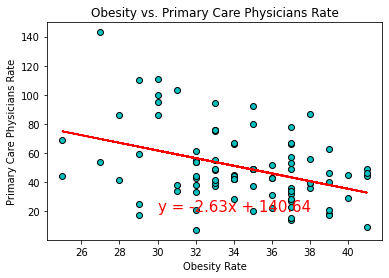

The r-squared value is: -0.38667593029688896


In [38]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_physician = ohio_analysis["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_physician)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_physician,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))


#### Obesity vs. High School Graduation Rate

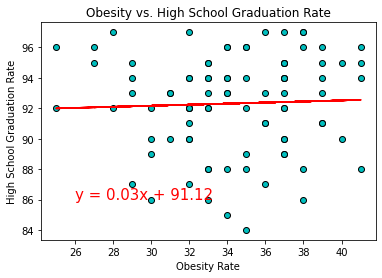

The r-squared value is: 0.04068527727508829


In [39]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_graduation = ohio_analysis["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_graduation)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_graduation,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,86),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity rate vs. % Unemployed

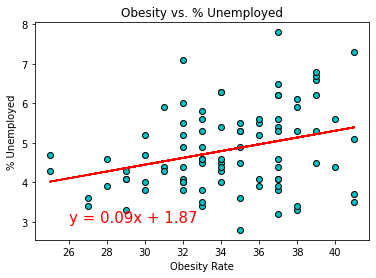

The r-squared value is: 0.3041473291712161


In [40]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_unemployed = ohio_analysis["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_unemployed)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_unemployed,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,3),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

In [41]:
ohio_analysis.dtypes

FIPS                                         int64
% Adults with Obesity                        int64
% Physically Inactive                        int64
% With Access to Exercise Opportunities      int64
Primary Care Physicians Rate                 int64
High School Graduation Rate                float64
% Unemployed                               float64
County and State                            object
Median Income                              float64
State                                       object
dtype: object

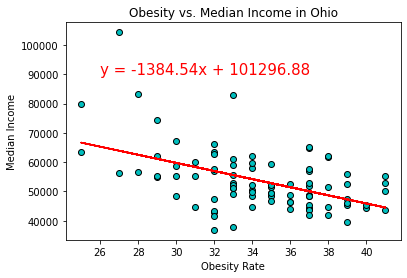

The r-squared value is: -0.48606554045367734


In [44]:
ohio_analysis = merged_df.loc[merged_df["State"] == " Ohio" ]
ohio_obesity_rate = ohio_analysis["% Adults with Obesity"]
ohio_median_income = ohio_analysis["Median Income"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(ohio_obesity_rate, ohio_median_income)
regress_values = ohio_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(ohio_obesity_rate,ohio_median_income,color="c",edgecolors="black")
plt.plot(ohio_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(26,90000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income in Ohio")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

## State of South Carolina

#### Obesity vs. % Physically Inactive

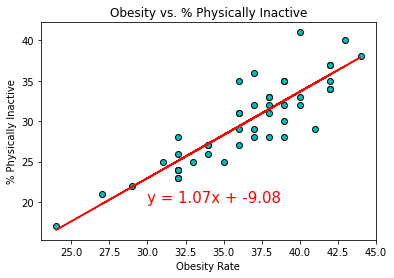

The r-squared value is: 0.8787360348055608


In [41]:
scarolina_analysis = merged_df.loc[merged_df["State"] == " South Carolina" ]
scarolina_obesity_rate = scarolina_analysis["% Adults with Obesity"]
scarolina_physical = scarolina_analysis["% Physically Inactive"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(scarolina_obesity_rate, scarolina_physical)
regress_values = scarolina_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(scarolina_obesity_rate,scarolina_physical,color="c",edgecolors="black")
plt.plot(scarolina_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(30,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Physically Inactive")
plt.title("Obesity vs. % Physically Inactive")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. % With Access to Exercise Opportunities

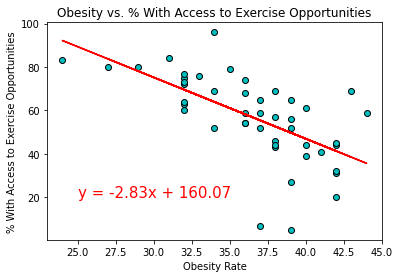

The r-squared value is: -0.6258510423494121


In [52]:
scarolina_analysis = merged_df.loc[merged_df["State"] == " South Carolina" ]
scarolina_obesity_rate = scarolina_analysis["% Adults with Obesity"]
scarolina_exercise = scarolina_analysis["% With Access to Exercise Opportunities"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(scarolina_obesity_rate, scarolina_exercise)
regress_values = scarolina_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(scarolina_obesity_rate,scarolina_exercise,color="c",edgecolors="black")
plt.plot(scarolina_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% With Access to Exercise Opportunities")
plt.title("Obesity vs. % With Access to Exercise Opportunities")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. Primary Care Physicians Rate

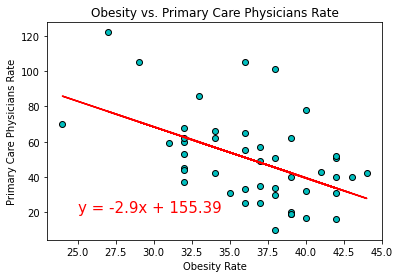

The r-squared value is: -0.501992500863181


In [51]:
scarolina_analysis = merged_df.loc[merged_df["State"] == " South Carolina" ]
scarolina_obesity_rate = scarolina_analysis["% Adults with Obesity"]
scarolina_physician = scarolina_analysis["Primary Care Physicians Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(scarolina_obesity_rate, scarolina_physician)
regress_values = scarolina_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(scarolina_obesity_rate,scarolina_physician,color="c",edgecolors="black")
plt.plot(scarolina_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,20),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Primary Care Physicians Rate")
plt.title("Obesity vs. Primary Care Physicians Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity vs. High School Graduation Rate

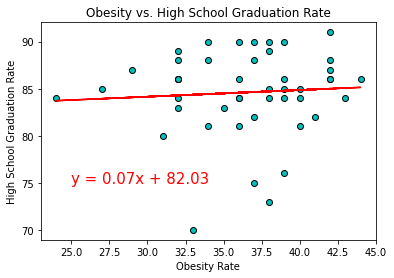

The r-squared value is: 0.06936100948747122


In [48]:
scarolina_analysis = merged_df.loc[merged_df["State"] == " South Carolina" ]
scarolina_obesity_rate = scarolina_analysis["% Adults with Obesity"]
scarolina_graduation = scarolina_analysis["High School Graduation Rate"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(scarolina_obesity_rate, scarolina_graduation)
regress_values = scarolina_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(scarolina_obesity_rate,scarolina_graduation,color="c",edgecolors="black")
plt.plot(scarolina_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,75),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("High School Graduation Rate")
plt.title("Obesity vs. High School Graduation Rate")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity rate vs. % Unemployed

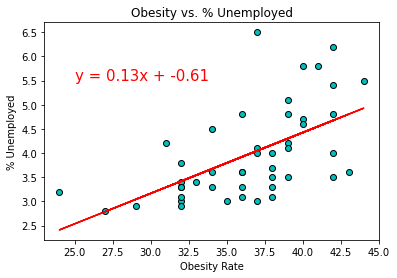

The r-squared value is: 0.5789630478322302


In [50]:
scarolina_analysis = merged_df.loc[merged_df["State"] == " South Carolina" ]
scarolina_obesity_rate = scarolina_analysis["% Adults with Obesity"]
scarolina_unemployed = scarolina_analysis["% Unemployed"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(scarolina_obesity_rate, scarolina_unemployed)
regress_values = scarolina_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(scarolina_obesity_rate,scarolina_unemployed,color="c",edgecolors="black")
plt.plot(scarolina_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,5.5),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("% Unemployed")
plt.title("Obesity vs. % Unemployed")
plt.show()

(print(f"The r-squared value is: {rvalue}"))

#### Obesity rate vs. median income

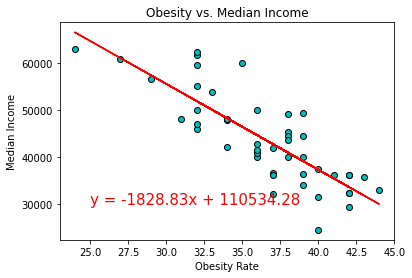

The r-squared value is: -0.818770295612129


In [54]:
scarolina_analysis = merged_df.loc[merged_df["State"] == " South Carolina" ]
scarolina_obesity_rate = scarolina_analysis["% Adults with Obesity"]
scarolina_median_income = scarolina_analysis["Median Income"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(scarolina_obesity_rate, scarolina_median_income)
regress_values = scarolina_obesity_rate * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(scarolina_obesity_rate,scarolina_median_income,color="c",edgecolors="black")
plt.plot(scarolina_obesity_rate,regress_values,"r-")
plt.annotate(line_eq,(25,30000),fontsize=15,color="red")
plt.xlabel("Obesity Rate")
plt.ylabel("Median Income")
plt.title("Obesity vs. Median Income")
plt.show()

(print(f"The r-squared value is: {rvalue}"))